In [3]:
import pandas_datareader.data as web
from fredapi import Fred


import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import hstack
from scipy import stats
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, LassoLarsCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

import warnings
import os

warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import pmdarima as pm
from pmdarima import model_selection

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

%matplotlib inline

Using TensorFlow backend.


In [4]:
start = datetime(2000,2,1)
end = datetime(2020,1,31)

In [5]:
AMT = web.DataReader('AMT', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
AMT = AMT.copy()
AMT.index = pd.to_datetime(AMT.index)
AMT = AMT.resample('MS').mean()
AMT['name'] = pd.Series()
AMT['name'] = 'AMT'

ELS = web.DataReader('ELS', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
ELS = ELS.copy()
ELS.index = pd.to_datetime(ELS.index)
ELS = ELS.resample('MS').mean()
ELS['name'] = pd.Series()
ELS['name'] = 'ELS'

PLD = web.DataReader('PLD', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
PLD = PLD.copy()
PLD.index = pd.to_datetime(PLD.index)
PLD = PLD.resample('MS').mean()
PLD['name'] = pd.Series()
PLD['name'] = 'PLD'

FR = web.DataReader('FR', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
FR = FR.copy()
FR.index = pd.to_datetime(FR.index)
FR = FR.resample('MS').mean()
FR['name'] = pd.Series()
FR['name'] = 'FR'


In [8]:
MAA = web.DataReader('MAA', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
MAA = MAA.copy()
MAA.index = pd.to_datetime(MAA.index)
MAA = MAA.resample('MS').mean()
MAA['name'] = pd.Series()
MAA['name'] = 'MAA'

SUI = web.DataReader('SUI', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
SUI = SUI.copy()
SUI.index = pd.to_datetime(SUI.index)
SUI = SUI.resample('MS').mean()
SUI['name'] = pd.Series()
SUI['name'] = 'SUI'

BXMT = web.DataReader('BXMT', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
BXMT = BXMT.copy()
BXMT.index = pd.to_datetime(BXMT.index)
BXMT = BXMT.resample('MS').mean()
BXMT['name'] = pd.Series()
BXMT['name'] = 'BXMT'

RHP = web.DataReader('RHP', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
RHP = RHP.copy()
RHP.index = pd.to_datetime(RHP.index)
RHP = RHP.resample('MS').mean()
RHP['name'] = pd.Series()
RHP['name'] = 'RHP'


In [9]:
reit_list = [AMT, PLD, ELS, FR, MAA, SUI, BXMT, RHP]
for reit in reit_list:
    reit['mid'] = (reit['high'] + reit['low'])/2
    reit.columns = ['open', 'high', 'low', 'close', 'volume', 'name', 'mid']
    reit.drop(['open', 'high', 'low', 'close', 'volume', 'name'], axis = 1, inplace = True)

## Exogenous Data Gathering

In [10]:
fred = Fred(api_key = 'aec5f13aa40d1af4edd587ffccceeb1a')

In [11]:
# LIBOR rate (USD1MTD156N)
usd1mtd156n = fred.get_series('usd1mtd156n', start, end)
usd1mtd156n = round(usd1mtd156n.resample('MS').mean(),2)
usd1mtd156n = pd.DataFrame(usd1mtd156n, index = usd1mtd156n.index, columns = ['usd1mtd156n'])

In [12]:
# 30 Year Fixed Rate Mortgage (MORTGAGE30US)
mortgage30us = fred.get_series('MORTGAGE30US', start, end)
mortgage30us = round(mortgage30us.resample('MS').mean(),2)
mortgage30us = pd.DataFrame(mortgage30us, index = mortgage30us.index, columns = ['mortgage30us'])

In [13]:
# 15 Year Fixed rate Mortgage (MORTGAGE15US)
mortgage15us = fred.get_series('MORTGAGE15US', start, end)
mortgage15us = round(mortgage15us.resample('MS').mean(),2)
mortgage15us = pd.DataFrame(mortgage15us, index = mortgage15us.index, columns = ['mortgage15us'])

In [14]:
# 3-Month AA Financial Commercial Paper Rate (DCPF3M)
dcpf3m = fred.get_series('DCPF3M', start, end)
dcpf3m = round(dcpf3m.resample('MS').mean(),2)
dcpf3m = pd.DataFrame(dcpf3m, index = dcpf3m.index, columns = ['dcpf3m'])

In [15]:
# 3-Month AA Nonfinancial Commercial Paper Rate (CPN3M)
cpn3m = fred.get_series('cpn3m', start, end)
cpn3m = round(cpn3m.resample('MS').mean(),2)
cpn3m = pd.DataFrame(cpn3m, index = dcpf3m.index, columns = ['cpn3m'])

In [16]:
# 1-Month AA Financial Commercial Paper Rate (DCPF1M)
dcpf1m = fred.get_series('dcpf1m', start, end)
dcpf1m = round(dcpf1m.resample('MS').mean(),2)
dcpf1m = pd.DataFrame(dcpf1m, index = dcpf3m.index, columns = ['dcpf1m'])

In [17]:
# Moody's Seasoned Aaa Corporate Bond Yield (AAA)
aaa = fred.get_series('AAA', start, end)
aaa = round(aaa.resample('MS').mean(),2)
aaa = pd.DataFrame(aaa, index = dcpf3m.index, columns = ['aaa'])

In [18]:
# Moody's Seasoned Baa Corporate Bond Yield (BAA)
baa = fred.get_series('BAA', start, end)
baa = round(baa.resample('MS').mean(),2)
baa = pd.DataFrame(baa, index = baa.index, columns = ['baa'])

In [19]:
# Effective Federal Funds Rate (DFF)
dff = fred.get_series('DFF', start, end)
dff = round(dff.resample('MS').mean(),2)
dff = pd.DataFrame(dff, index = dff.index, columns = ['dff'])

In [20]:
# Eighth District Flexible Rate on Seasonal Credit (FLEXSC)
flexsc = fred.get_series('flexsc', start, end)
flexsc = round(flexsc.resample('MS').mean(),2)
flexsc = pd.DataFrame(flexsc, index = flexsc.index, columns = ['flexsc'])

In [21]:
# 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity (T10Y2Y)
t10y2y = fred.get_series('t10y2y', start, end)
t10y2y = round(t10y2y.resample('MS').mean(),2)
t10y2y = pd.DataFrame(t10y2y, index = t10y2y.index, columns = ['t10y2y'])

In [22]:
# 10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity (T10Y3M)
t10y3m = fred.get_series('t10y3m', start, end)
t10y3m = round(t10y3m.resample('MS').mean(),2)
t10y3m = pd.DataFrame(t10y3m, index = t10y3m.index, columns = ['t10y3m'])

In [23]:
# TED Spread (TEDRATE)
tedrate = fred.get_series('tedrate', start, end)
tedrate = round(tedrate.resample('MS').mean(),2)
tedrate = pd.DataFrame(tedrate, index = tedrate.index, columns = ['tedrate'])

In [24]:
# 10-Year Treasury Constant Maturity Minus Federal Funds Rate (T10YFF)
t10yff = fred.get_series('T10YFF', start, end)
t10yff = round(t10yff.resample('MS').mean(),2)
t10yff = pd.DataFrame(t10yff, index = t10yff.index, columns = ['t10yff'])

In [25]:
# 5-Year Treasury Constant Maturity Minus Federal Funds Rate (T5YFF)
t5yff = fred.get_series('t5yff', start, end)
t5yff = round(t5yff.resample('MS').mean(),2)
t5yff = pd.DataFrame(t5yff, index = t5yff.index, columns = ['t5yff'])

In [26]:
# 6-Month Treasury Bill Minus Federal Funds Rate (TB6SMFFM)
tb6smffm = fred.get_series('tb6smffm', start, end)
tb6smffm = round(tb6smffm.resample('MS').mean(),2)
tb6smffm = pd.DataFrame(tb6smffm, index = tb6smffm.index, columns = ['tb6smffm'])

In [27]:
# 3-Month London Interbank Offered Rate (LIBOR), based on U.S. Dollar (USD3MTD156N)
usd3mtd156n = fred.get_series('usd3mtd156n', start, end)
usd3mtd156n = round(usd3mtd156n.resample('MS').mean(),2)
usd3mtd156n = pd.DataFrame(usd3mtd156n, index = usd3mtd156n.index, columns = ['usd3mtd156n'])

In [28]:
# 12-Month London Interbank Offered Rate (LIBOR), based on U.S. Dollar (USD12MD156N)
usd12md156n = fred.get_series('usd12md156n', start, end)
usd12md156n = round(usd12md156n.resample('MS').mean(),2)
usd12md156n = pd.DataFrame(usd12md156n, index = usd12md156n.index, columns = ['usd12md156n'])

In [29]:
# 1-Week London Interbank Offered Rate (LIBOR), based on Euro (EUR1WKD156N)
eur1wkd156n = fred.get_series('eur1wkd156n', start, end)
eur1wkd156n = round(eur1wkd156n.resample('MS').mean(),2)
eur1wkd156n = pd.DataFrame(eur1wkd156n, index = eur1wkd156n.index, columns = ['eur1wkd156n'])

In [30]:
# Bank Prime Loan Rate (MPRIME)
mprime = fred.get_series('mprime', start, end)
mprime = round(mprime.resample('MS').mean(),2)
mprime = pd.DataFrame(mprime, index = mprime.index, columns = ['mprime'])

In [31]:
# 3-Month Treasury Bill: Secondary Market Rate (TB3MS)
tb3ms = fred.get_series('tb3ms', start, end)
tb3ms = round(tb3ms.resample('MS').mean(),2)
tb3ms = pd.DataFrame(tb3ms, index = tb3ms.index, columns = ['tb3ms'])

In [32]:
# 1-Year Treasury Bill: Secondary Market Rate (TB1YR)
tb1yr = fred.get_series('tb1yr', start, end)
tb1yr = round(tb1yr.resample('MS').mean(),2)
tb1yr = pd.DataFrame(tb1yr, index = tb1yr.index, columns = ['tb1yr'])

In [33]:
# 6-Month Treasury Bill: Secondary Market Rate (DTB6)
dtb6 = fred.get_series('dtb6', start, end)
dtb6 = round(dtb6.resample('MS').mean(),2)
dtb6= pd.DataFrame(dtb6, index = dtb6.index, columns = ['dtb6'])

In [34]:
# 10-Year Treasury Constant Maturity Rate (DGS10)
dgs10 = fred.get_series('dgs10', start, end)
dgs10 = round(dgs10.resample('MS').mean(),2)
dgs10 = pd.DataFrame(dgs10, index = dgs10.index, columns = ['dgs10'])

In [35]:
# 1-Year Treasury Constant Maturity Rate (DGS1)
dgs1 = fred.get_series('dgs1', start, end)
dgs1 = round(dgs1.resample('MS').mean(),2)
dgs1 = pd.DataFrame(dgs1, index = dgs1.index, columns = ['dgs1'])

In [36]:
# 10-Year Treasury Inflation-Indexed Security, Constant Maturity (DFII10)
dfii10 = fred.get_series('dfii10', start, end)
dfii10 = round(dfii10.resample('MS').mean(),2)
dfii10 = pd.DataFrame(dfii10, index = dfii10.index, columns = ['dfii10'])

In [37]:
# 3-Month Treasury Constant Maturity Rate (DGS3MO)
dgs3mo = fred.get_series('dgs3mo', start, end)
dgs3mo = round(dgs3mo.resample('MS').mean(),2)
dgs3mo = pd.DataFrame(dgs3mo, index = dgs3mo.index, columns = ['dgs3mo'])

In [38]:
# 30-Year Treasury Constant Maturity Rate (DGS30)
dgs30 = fred.get_series('dgs30', start, end)
dgs30 = round(dgs30.resample('MS').mean(),2)
dgs30 = pd.DataFrame(dgs30, index = dgs30.index, columns = ['dgs30'])

In [39]:
# U.S. / Euro Foreign Exchange Rate (DEXUSEU)
dexuseu = fred.get_series('dexuseu', start, end)
dexuseu = round(dexuseu.resample('MS').mean(),2)
dexuseu = pd.DataFrame(dexuseu, index = dexuseu.index, columns = ['dexuseu'])

In [40]:
# China / U.S. Foreign Exchange Rate (DEXCHUS)
dexchus = fred.get_series('dexchus', start, end)
dexchus = round(dexchus.resample('MS').mean(),2)
dexchus = pd.DataFrame(dexchus, index = dexchus.index, columns = ['dexchus'])

In [41]:
# U.S. / U.K. Foreign Exchange Rate (DEXUSUK)
dexusuk = fred.get_series('dexusuk', start, end)
dexusuk = round(dexusuk.resample('MS').mean(),2)
dexusuk = pd.DataFrame(dexusuk, index = dexusuk.index, columns = ['dexusuk'])

In [42]:
# Singapore / U.S. Foreign Exchange Rate (DEXSIUS)
dexsius = fred.get_series('dexsius', start, end)
dexsius = round(dexsius.resample('MS').mean(),2)
dexsius = pd.DataFrame(dexsius, index = dexsius.index, columns = ['dexsius'])

In [43]:
# NASDAQ Composite Index (NASDAQCOM)
nasdaqcom = fred.get_series('nasdaqcom', start, end)
nasdaqcom = round(nasdaqcom.resample('MS').mean(),2)
nasdaqcom = pd.DataFrame(nasdaqcom, index = nasdaqcom.index, columns = ['nasdaqcom'])

In [44]:
# Wilshire US Real Estate Investment Trust Total Market Index (Wilshire US REIT)(WILLREITIND)
willreitind = fred.get_series('willreitind', start, end)
willreitind = round(willreitind.resample('MS').mean(),2)
willreitind = pd.DataFrame(willreitind, index = willreitind.index, columns = ['willreitind'])

In [45]:
# Wilshire US Real Estate Securities Price Index (Wilshire US RESI) (WILLRESIPR)
willresipr = fred.get_series('willresipr', start, end)
willresipr = round(willresipr.resample('MS').mean(),2)
willresipr = pd.DataFrame(willresipr, index = willresipr.index, columns = ['willresipr'])

In [46]:
# Wilshire US Large-Cap Total Market Index (WILLLRGCAP)
willlrgcap = fred.get_series('willlrgcap', start, end)
willlrgcap = round(willlrgcap.resample('MS').mean(),2)
willlrgcap = pd.DataFrame(willlrgcap, index = willlrgcap.index, columns = ['willlrgcap'])

In [47]:
# Wilshire US Small-Cap Total Market Index (WILLSMLCAP)
willsmlcap = fred.get_series('willsmlcap', start, end)
willsmlcap = round(willsmlcap.resample('MS').mean(),2)
willsmlcap = pd.DataFrame(willsmlcap, index = willsmlcap.index, columns = ['willsmlcap'])

In [48]:
# CBOE Volatility Index: VIX (VIXCLS)
vixcls = fred.get_series('vixcls', start, end)
vixcls = round(vixcls.resample('MS').mean(),2)
vixcls = pd.DataFrame(vixcls, index = vixcls.index, columns = ['vixcls'])

In [49]:
# CBOE DJIA Volatility Index (VXDCLS)
vxdcls = fred.get_series('vxdcls', start, end)
vxdcls = round(vxdcls.resample('MS').mean(),2)
vxdcls = pd.DataFrame(vxdcls, index = vxdcls.index, columns = ['vxdcls'])

In [50]:
# St. Louis Fed Financial Stress Index (STLFSI)
stlfsi = fred.get_series('stlfsi', start, end)
stlfsi = round(stlfsi.resample('MS').mean(),2)
stlfsi = pd.DataFrame(stlfsi, index = stlfsi.index, columns = ['stlfsi'])

In [51]:
# Chicago Fed National Financial Conditions Index (NFCI)
nfci = fred.get_series('nfci', start, end)
nfci = round(nfci.resample('MS').mean(),2)
nfci = pd.DataFrame(nfci, index = nfci.index, columns = ['nfci'])

In [52]:
# Borrowings, All Commercial Banks (H8B3094NCBA)
h8b3094ncba = fred.get_series('h8b3094ncba', start, end)
h8b3094ncba = round(h8b3094ncba.resample('MS').mean(),2)
h8b3094ncba = pd.DataFrame(h8b3094ncba, index = h8b3094ncba.index, columns = ['h8b3094ncba'])

In [53]:
# Bank Credit, Domestically Chartered Commercial Banks (BC0DCBW027NBOG)
bc0dcbw027nbog = fred.get_series('bc0dcbw027nbog', start, end)
bc0dcbw027nbog = round(bc0dcbw027nbog.resample('MS').mean(),2)
bc0dcbw027nbog = pd.DataFrame(bc0dcbw027nbog, index = bc0dcbw027nbog.index, columns = ['bc0dcbw027nbog'])

In [54]:
# Cash Assets, Domestically Chartered Commercial Banks (CASDCBW027NBOG)
casdcbw027nbog = fred.get_series('casdcbw027nbog', start, end)
casdcbw027nbog = round(casdcbw027nbog.resample('MS').mean(),2)
casdcbw027nbog = pd.DataFrame(casdcbw027nbog, index = casdcbw027nbog.index, columns = ['casdcbw027nbog'])

In [55]:
# Commercial and Industrial Loans, Domestically Chartered Commercial Banks (CILDCBW027NBOG)
cildcbw027nbog = fred.get_series('cildcbw027nbog', start, end)
cildcbw027nbog = round(cildcbw027nbog.resample('MS').mean(),2)
cildcbw027nbog = pd.DataFrame(cildcbw027nbog, index = cildcbw027nbog.index, columns = ['cildcbw027nbog'])

In [56]:
# Deposits, Domestically Chartered Commercial Banks (DPSDCBW027NBOG)
dpsdcbw027nbog = fred.get_series('dpsdcbw027nbog', start, end)
dpsdcbw027nbog = round(dpsdcbw027nbog.resample('MS').mean(),2)
dpsdcbw027nbog = pd.DataFrame(dpsdcbw027nbog, index = dpsdcbw027nbog.index, columns = ['dpsdcbw027nbog'])

In [57]:
# Real Estate Loans: Residential Real Estate Loans: Revolving Home Equity Loans, Domestically Chartered Commercial Banks (RHEDCBW027NBOG)
rhedcbw027nbog = fred.get_series('rhedcbw027nbog', start, end)
rhedcbw027nbog = round(rhedcbw027nbog.resample('MS').mean(),2)
rhedcbw027nbog = pd.DataFrame(rhedcbw027nbog, index = rhedcbw027nbog.index, columns = ['rhedcbw027nbog'])

In [58]:
# Consumer Loans, All Commercial Banks (CLSACBW027NBOG)
clsacbw027nbog = fred.get_series('clsacbw027nbog', start, end)
clsacbw027nbog = round(clsacbw027nbog.resample('MS').mean(),2)
clsacbw027nbog = pd.DataFrame(clsacbw027nbog, index = clsacbw027nbog.index, columns = ['clsacbw027nbog'])

In [59]:
# Deposits, All Commercial Banks (DPSACBW027NBOG)
dpsacbw027nbog = fred.get_series('dpsacbw027nbog', start, end)
dpsacbw027nbog = round(dpsacbw027nbog.resample('MS').mean(),2)
dpsacbw027nbog = pd.DataFrame(dpsacbw027nbog, index = dpsacbw027nbog.index, columns = ['dpsacbw027nbog'])

In [60]:
# Real Estate Loans, All Commercial Banks (RELACBW027NBOG)
relacbw027nbog = fred.get_series('relacbw027nbog', start, end)
relacbw027nbog = round(relacbw027nbog.resample('MS').mean(),2)
relacbw027nbog = pd.DataFrame(relacbw027nbog, index = relacbw027nbog.index, columns = ['relacbw027nbog'])

In [61]:
# Real Estate Loans: Residential Real Estate Loans: Revolving Home Equity Loans, All Commercial Banks (RHEACBW027NBOG)
rheacbw027nbog = fred.get_series('rheacbw027nbog', start, end)
rheacbw027nbog = round(rheacbw027nbog.resample('MS').mean(),2)
rheacbw027nbog = pd.DataFrame(rheacbw027nbog, index = rheacbw027nbog.index, columns = ['rheacbw027nbog'])

In [62]:
# Total Assets, All Commercial Banks (TLAACBW027NBOG)
tlaacbw027nbog = fred.get_series('tlaacbw027nbog', start, end)
tlaacbw027nbog = round(tlaacbw027nbog.resample('MS').mean(),2)
tlaacbw027nbog = pd.DataFrame(tlaacbw027nbog, index = tlaacbw027nbog.index, columns = ['tlaacbw027nbog'])

In [63]:
# Total Liabilities, All Commercial Banks (TLBACBW027NBOG)
tlbacbw027nbog = fred.get_series('tlbacbw027nbog', start, end)
tlbacbw027nbog = round(tlbacbw027nbog.resample('MS').mean(),2)
tlbacbw027nbog = pd.DataFrame(tlbacbw027nbog, index = tlbacbw027nbog.index, columns = ['tlbacbw027nbog'])

In [64]:
# Commercial and Industrial Loans, All Commercial Banks (TOTCI)
totci = fred.get_series('totci', start, end)
totci = round(totci.resample('MS').mean(),2)
totci = pd.DataFrame(totci, index = totci.index, columns = ['totci'])

In [65]:
# Economic Policy Uncertainty Index for United States (USEPUINDXD)
usepuindxd = fred.get_series('usepuindxd', start, end)
usepuindxd = round(usepuindxd.resample('MS').mean(),2)
usepuindxd = pd.DataFrame(usepuindxd, index = usepuindxd.index, columns = ['usepuindxd'])

In [66]:
# Equity Market-related Economic Uncertainty Index (WLEMUINDXD)
wlemuindxd = fred.get_series('wlemuindxd', start, end)
wlemuindxd = round(wlemuindxd.resample('MS').mean(),2)
wlemuindxd = pd.DataFrame(wlemuindxd, index = wlemuindxd.index, columns = ['wlemuindxd'])

In [67]:
# Equity Market Volatility Tracker: Financial Crises (EMVFINCRISES)
emvfincrises = fred.get_series('emvfincrises', start, end)
emvfincrises = round(emvfincrises.resample('MS').mean(),2)
emvfincrises = pd.DataFrame(emvfincrises, index = emvfincrises.index, columns = ['emvfincrises'])

In [68]:
# Price Pressures Measure (STLPPM)
stlppm = fred.get_series('stlppm', start, end)
stlppm = round(stlppm.resample('MS').mean(),2)
stlppm = pd.DataFrame(stlppm, index = stlppm.index, columns = ['stlppm'])

In [69]:
rates_list = [usd1mtd156n, mortgage30us, mortgage15us, dcpf3m, cpn3m, dcpf1m, aaa, baa, dff, flexsc, t10y2y, t10y3m, tedrate, t10yff, t5yff, tb6smffm, usd3mtd156n, usd12md156n, 
              eur1wkd156n, mprime, tb3ms, tb1yr, dtb6, dgs10, dfii10, dgs3mo, dgs30, dexuseu, dexchus, dexusuk, dexsius, nasdaqcom, willreitind, willlrgcap, willsmlcap, vxdcls, 
              stlfsi, nfci, h8b3094ncba, bc0dcbw027nbog, casdcbw027nbog, cildcbw027nbog, dpsdcbw027nbog, rhedcbw027nbog, clsacbw027nbog, dpsacbw027nbog, relacbw027nbog, rheacbw027nbog, 
              tlaacbw027nbog, tlbacbw027nbog, totci, usepuindxd, wlemuindxd, emvfincrises, stlppm]
rates_df = pd.concat(rates_list, axis = 1)
rates_df.tail(5)

,usd1mtd156n,mortgage30us,mortgage15us,dcpf3m,cpn3m,dcpf1m,aaa,baa,dff,flexsc,...,dpsacbw027nbog,relacbw027nbog,rheacbw027nbog,tlaacbw027nbog,tlbacbw027nbog,totci,usepuindxd,wlemuindxd,emvfincrises,stlppm
2019-09-01,2.04,3.61,3.12,2.03,1.95,2.02,3.03,3.91,2.04,2.08,...,12921.51,4542.70,329.93,17489.44,15505.06,2364.67,118.31,66.56,2.05,0.03
2019-10-01,1.88,3.69,3.14,1.88,1.80,1.83,3.01,3.92,1.83,1.90,...,13048.16,4565.98,326.53,17574.58,15607.03,2353.50,98.00,70.15,2.23,0.03
2019-11-01,1.74,3.70,3.16,1.77,1.62,1.61,3.06,3.94,1.55,1.72,...,13199.68,4587.52,323.88,17723.99,15755.28,2359.68,81.04,54.55,1.65,0.05
2019-12-01,1.75,3.72,3.18,1.76,1.70,1.65,3.01,3.88,1.55,1.70,...,13315.01,4602.73,321.61,17835.82,15861.60,2353.74,121.21,82.94,3.79,0.05
2020-01-01,1.67,3.62,3.07,1.65,1.58,1.57,2.94,3.77,1.55,1.63,...,13313.75,4601.30,319.09,17776.54,15816.22,2342.33,110.56,90.67,2.79,0.06


## Clean Rates DF

In [70]:
rates_df.loc[:, rates_df.isna().any()]

,cpn3m,tb1yr,dfii10,dgs30
2000-02-01,5.87,5.84,NaN,6.23
2000-03-01,6.00,5.86,NaN,6.05
2000-04-01,6.11,5.80,NaN,5.85
2000-05-01,6.54,5.94,NaN,6.15
2000-06-01,6.57,5.83,NaN,5.93
...,...,...,...,...
2019-09-01,1.95,1.75,0.11,2.16
2019-10-01,1.80,1.57,0.15,2.19
2019-11-01,1.62,1.53,0.17,2.28
2019-12-01,1.70,1.51,0.14,2.30


In [71]:
rates_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2000-02-01 to 2020-01-01
Freq: MS
Data columns (total 55 columns):
usd1mtd156n       240 non-null float64
mortgage30us      240 non-null float64
mortgage15us      240 non-null float64
dcpf3m            240 non-null float64
cpn3m             236 non-null float64
dcpf1m            240 non-null float64
aaa               240 non-null float64
baa               240 non-null float64
dff               240 non-null float64
flexsc            240 non-null float64
t10y2y            240 non-null float64
t10y3m            240 non-null float64
tedrate           240 non-null float64
t10yff            240 non-null float64
t5yff             240 non-null float64
tb6smffm          240 non-null float64
usd3mtd156n       240 non-null float64
usd12md156n       240 non-null float64
eur1wkd156n       240 non-null float64
mprime            240 non-null float64
tb3ms             240 non-null float64
tb1yr             159 non-null float64
dtb6     

In [72]:
rates_df.drop(labels = ['tb1yr', 'dgs30', 'dfii10'], axis = 1, inplace = True)

In [73]:
rates_df.cpn3m = rates_df.cpn3m.ffill()

In [84]:
AMT_rates = pd.concat([AMT, rates_df], axis = 1)
ELS_rates = pd.concat([ELS, rates_df], axis = 1)
PLD_rates = pd.concat([PLD, rates_df], axis = 1)
FR_rates = pd.concat([FR, rates_df], axis = 1)
MAA_rates = pd.concat([MAA, rates_df], axis = 1)
SUI_rates = pd.concat([SUI, rates_df], axis = 1)
BXMT_rates = pd.concat([BXMT, rates_df], axis = 1)
RHP_rates = pd.concat([RHP, rates_df], axis = 1)
indicators_dict = {'AMT': AMT_rates, 'ELS': ELS_rates, 'PLD': PLD_rates, 'FR':FR_rates, 'MAA': MAA_rates, 'SUI': SUI_rates, 'BXMT': BXMT_rates, 'RHP': RHP_rates}

In [85]:
AMT_rates

,mid,usd1mtd156n,mortgage30us,mortgage15us,dcpf3m,cpn3m,dcpf1m,aaa,baa,dff,...,dpsacbw027nbog,relacbw027nbog,rheacbw027nbog,tlaacbw027nbog,tlbacbw027nbog,totci,usepuindxd,wlemuindxd,emvfincrises,stlppm
2000-02-01,43.515625,5.89,8.33,7.93,5.90,5.87,5.78,7.68,8.29,5.73,...,3490.25,1486.01,105.51,5638.25,5157.79,1016.61,50.60,45.27,0.35,0.30
2000-03-01,50.116739,6.05,8.24,7.83,6.03,6.00,5.94,7.68,8.37,5.85,...,3521.57,1510.16,107.31,5685.93,5198.06,1024.58,64.99,46.42,0.90,0.19
2000-04-01,44.443684,6.15,8.15,7.80,6.15,6.11,6.03,7.64,8.40,6.02,...,3584.93,1531.49,110.75,5747.53,5262.45,1033.44,59.76,88.46,1.04,0.65
2000-05-01,42.183864,6.54,8.51,8.18,6.57,6.54,6.41,7.99,8.90,6.27,...,3563.07,1559.57,113.35,5821.97,5336.37,1051.14,77.52,55.96,0.63,0.30
2000-06-01,41.465000,6.65,8.29,7.99,6.59,6.57,6.53,7.67,8.48,6.53,...,3581.19,1578.90,114.16,5841.58,5345.38,1062.59,67.24,74.91,0.52,0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-01,224.336473,2.04,3.61,3.12,2.03,1.95,2.02,3.03,3.91,2.04,...,12921.51,4542.70,329.93,17489.44,15505.06,2364.67,118.31,66.56,2.05,0.03
2019-10-01,223.061287,1.88,3.69,3.14,1.88,1.80,1.83,3.01,3.92,1.83,...,13048.16,4565.98,326.53,17574.58,15607.03,2353.50,98.00,70.15,2.23,0.03
2019-11-01,211.425463,1.74,3.70,3.16,1.77,1.62,1.61,3.06,3.94,1.55,...,13199.68,4587.52,323.88,17723.99,15755.28,2359.68,81.04,54.55,1.65,0.05
2019-12-01,217.928145,1.75,3.72,3.18,1.76,1.70,1.65,3.01,3.88,1.55,...,13315.01,4602.73,321.61,17835.82,15861.60,2353.74,121.21,82.94,3.79,0.05


In [86]:
def rmse_cv(model, X, y):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [93]:
def lasso_reg(dataframe):
    
    target = dataframe['mid']
    dataframe = dataframe.drop(['mid'], axis = 1)
    
    scale = MinMaxScaler()
    rates_trans = scale.fit_transform(dataframe)
    
    model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(dataframe, target)
    rmse_cv(model_lasso, dataframe, target).mean()
    
    coef = pd.Series(model_lasso.coef_, index = dataframe.columns)
    
    print(coef)
    print(' ')
    print("Lasso picked " + str(sum(coef != 0)) + "variables and eliminated the other" + str(sum(coef == 0)) + "variables")
    
    imp_coef = pd.concat([coef.sort_values().head(26),
                          coef.sort_values().tail(26)])
    matplotlib.rcParams['figure.figsize'] = (8,8)
    imp_coef.plot(kind = 'barh')
    plt.title("Coefficients in the Lasso Model")
    plt.show()
    
    matplotlib.rcParams['figure.figsize'] = (8,8)
    preds = pd.DataFrame({"preds":model_lasso.predict(dataframe), "true":target})
    preds["residuals"] = preds["true"] - preds["preds"]
    preds.plot(x = "preds", y = "residuals",kind = "scatter")

usd1mtd156n       0.000000
mortgage30us     -0.000000
mortgage15us     -0.000000
dcpf3m           -0.000000
cpn3m             0.000000
dcpf1m            0.000000
aaa               0.000000
baa               0.000000
dff               0.000000
flexsc            0.000000
t10y2y            0.000000
t10y3m           -0.000000
tedrate          -0.000000
t10yff           -0.000000
t5yff            -0.000000
tb6smffm         -0.000000
usd3mtd156n      -0.000000
usd12md156n      -0.000000
eur1wkd156n       0.000000
mprime            0.000000
tb3ms             0.000000
dtb6             -0.000000
dgs10             0.000000
dgs3mo            0.000000
dexuseu           0.000000
dexchus          -0.000000
dexusuk          -0.000000
dexsius          -0.000000
nasdaqcom         0.010890
willreitind       0.001919
willlrgcap        0.003302
willsmlcap       -0.002159
vxdcls           -0.046691
stlfsi           -0.000000
nfci              0.000000
h8b3094ncba      -0.000029
bc0dcbw027nbog   -0.003022
c

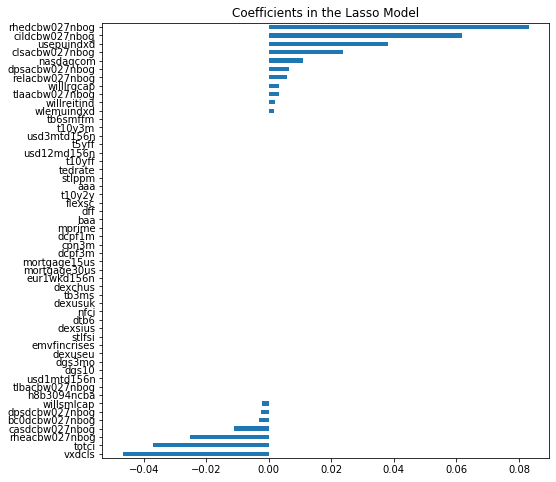

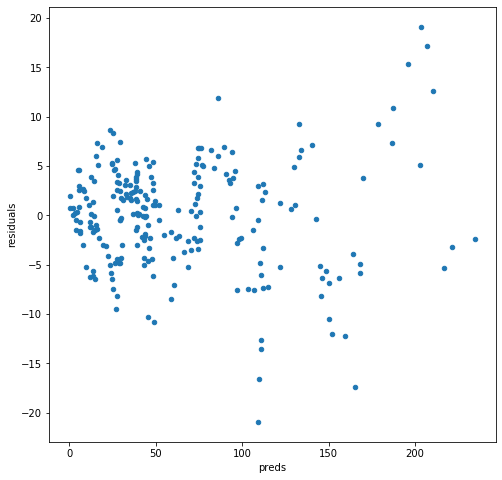

In [94]:
lasso_reg(AMT_rates)

usd1mtd156n      -0.000000
mortgage30us     -0.000000
mortgage15us     -0.000000
dcpf3m           -0.000000
cpn3m            -0.000000
dcpf1m           -0.000000
aaa              -0.000000
baa              -0.000000
dff              -0.000000
flexsc           -0.000000
t10y2y           -0.000000
t10y3m           -0.000000
tedrate          -0.000000
t10yff           -0.000000
t5yff            -0.000000
tb6smffm         -0.000000
usd3mtd156n      -0.000000
usd12md156n      -0.000000
eur1wkd156n      -0.000000
mprime           -0.000000
tb3ms            -0.000000
dtb6             -0.000000
dgs10            -0.000000
dgs3mo           -0.000000
dexuseu           0.000000
dexchus          -0.000000
dexusuk          -0.000000
dexsius          -0.000000
nasdaqcom         0.005112
willreitind       0.004831
willlrgcap       -0.001561
willsmlcap        0.000154
vxdcls            0.095614
stlfsi           -0.000000
nfci              0.000000
h8b3094ncba      -0.000028
bc0dcbw027nbog    0.016392
c

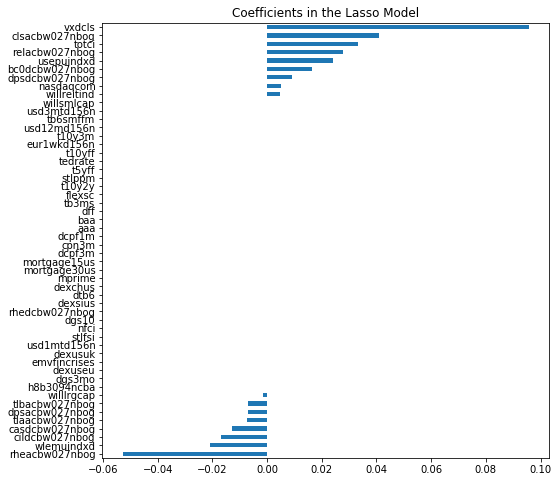

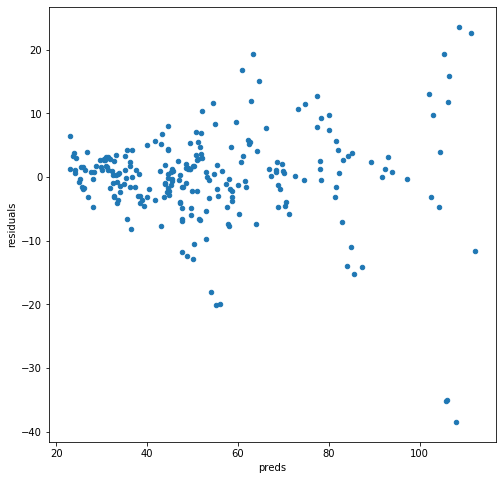

In [95]:
lasso_reg(ELS_rates)

usd1mtd156n       0.000000
mortgage30us     -0.000000
mortgage15us     -0.000000
dcpf3m            0.000000
cpn3m             0.000000
dcpf1m            0.000000
aaa              -0.000000
baa              -0.000000
dff               0.000000
flexsc            0.000000
t10y2y           -0.000000
t10y3m           -0.000000
tedrate           0.000000
t10yff           -0.000000
t5yff            -0.000000
tb6smffm         -0.000000
usd3mtd156n       0.000000
usd12md156n       0.000000
eur1wkd156n       0.000000
mprime            0.000000
tb3ms             0.000000
dtb6              0.000000
dgs10            -0.000000
dgs3mo            0.000000
dexuseu           0.000000
dexchus          -0.000000
dexusuk           0.000000
dexsius          -0.000000
nasdaqcom        -0.003729
willreitind       0.005984
willlrgcap        0.000931
willsmlcap        0.000033
vxdcls           -0.000000
stlfsi            0.000000
nfci              0.000000
h8b3094ncba       0.000008
bc0dcbw027nbog   -0.011700
c

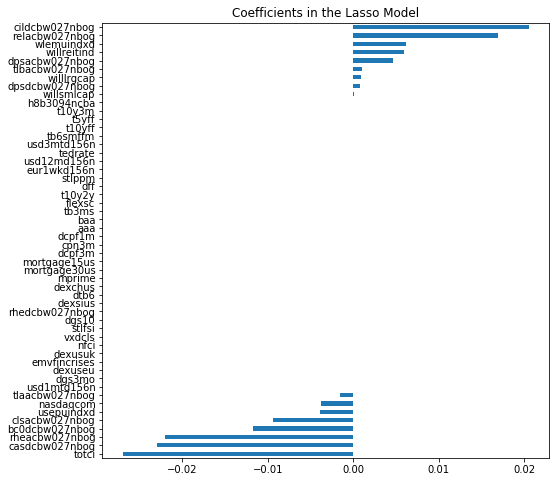

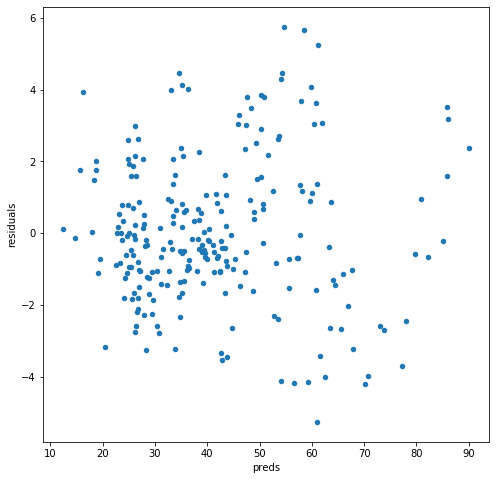

In [97]:
lasso_reg(PLD_rates)

usd1mtd156n       -3.197451
mortgage30us      -1.248196
mortgage15us      -2.976175
dcpf3m             4.080561
cpn3m             -0.192908
dcpf1m            -0.888217
aaa               -0.698094
baa               -1.452166
dff                4.316908
flexsc            -0.429874
t10y2y            -0.000000
t10y3m             2.986316
tedrate           -2.349787
t10yff             0.504435
t5yff             -1.699348
tb6smffm           5.316759
usd3mtd156n        1.378603
usd12md156n        0.968437
eur1wkd156n        1.049401
mprime            -0.948908
tb3ms              0.000000
dtb6               0.596743
dgs10              0.549402
dgs3mo            -1.052516
dexuseu            5.408603
dexchus            3.530692
dexusuk           13.180269
dexsius           21.710629
nasdaqcom         -0.005058
willreitind        0.003777
willlrgcap         0.000445
willsmlcap         0.000195
vxdcls            -0.221862
stlfsi             2.818409
nfci               4.603179
h8b3094ncba        0

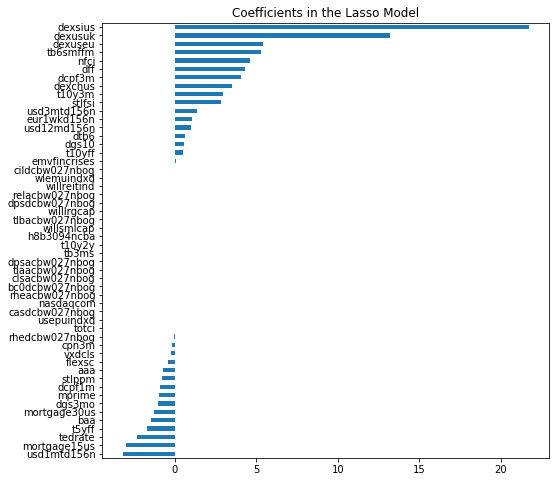

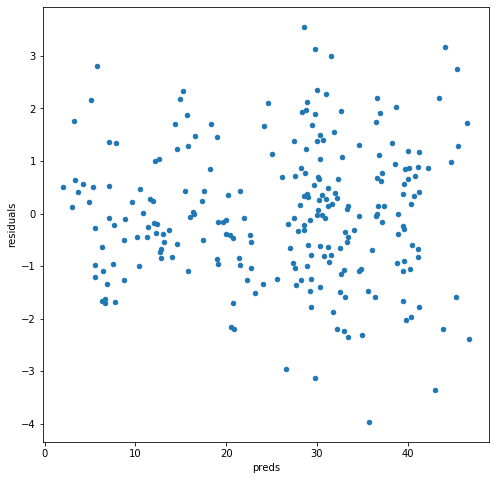

In [98]:
lasso_reg(FR_rates)

usd1mtd156n      -0.000000e+00
mortgage30us      0.000000e+00
mortgage15us      0.000000e+00
dcpf3m           -0.000000e+00
cpn3m            -0.000000e+00
dcpf1m           -0.000000e+00
aaa               2.343652e+00
baa               0.000000e+00
dff              -4.289260e-02
flexsc           -0.000000e+00
t10y2y            0.000000e+00
t10y3m            0.000000e+00
tedrate          -0.000000e+00
t10yff            6.728929e-01
t5yff             0.000000e+00
tb6smffm          0.000000e+00
usd3mtd156n      -0.000000e+00
usd12md156n       0.000000e+00
eur1wkd156n       0.000000e+00
mprime           -0.000000e+00
tb3ms            -0.000000e+00
dtb6             -0.000000e+00
dgs10            -0.000000e+00
dgs3mo           -0.000000e+00
dexuseu          -0.000000e+00
dexchus           0.000000e+00
dexusuk          -0.000000e+00
dexsius           0.000000e+00
nasdaqcom         3.751377e-03
willreitind       9.870266e-03
willlrgcap        3.134010e-04
willsmlcap       -8.087405e-04
vxdcls  

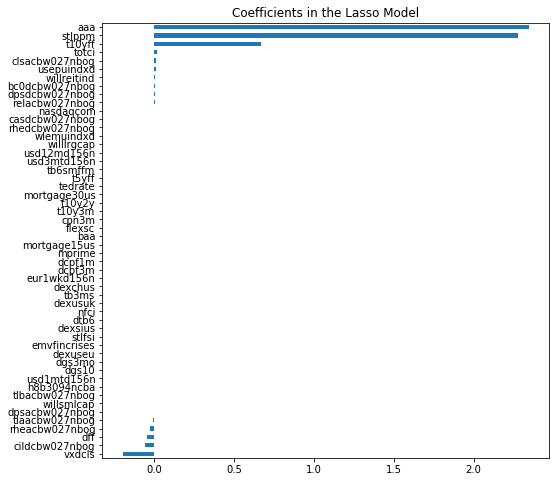

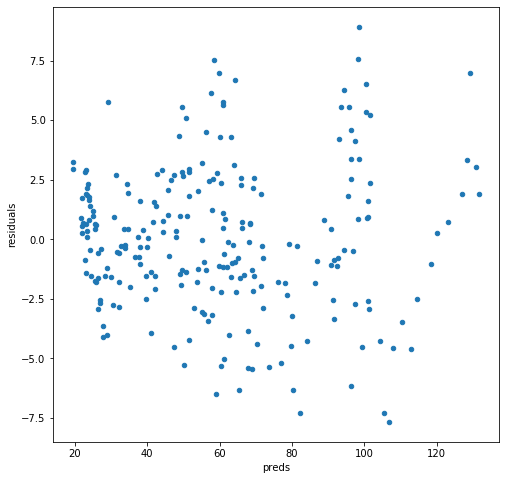

In [99]:
lasso_reg(MAA_rates)

usd1mtd156n       -6.150674
mortgage30us      -6.380501
mortgage15us       1.752013
dcpf3m            -3.148918
cpn3m              4.131991
dcpf1m             2.672646
aaa                3.361874
baa               -3.957072
dff               -1.947832
flexsc            -0.524580
t10y2y             1.939846
t10y3m            -3.526480
tedrate           -7.173871
t10yff             0.000000
t5yff              4.620969
tb6smffm          -0.911583
usd3mtd156n        2.048170
usd12md156n       -3.695239
eur1wkd156n       -0.892843
mprime             6.780468
tb3ms             -2.496501
dtb6              -0.639512
dgs10             -0.604216
dgs3mo             0.764150
dexuseu            1.695915
dexchus            6.677753
dexusuk          -17.984581
dexsius            8.264256
nasdaqcom          0.004663
willreitind        0.007222
willlrgcap         0.001563
willsmlcap        -0.000635
vxdcls            -0.034243
stlfsi            16.003052
nfci              -8.500438
h8b3094ncba       -0

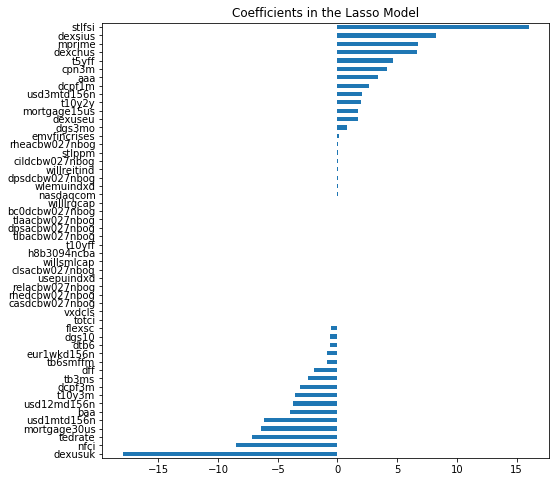

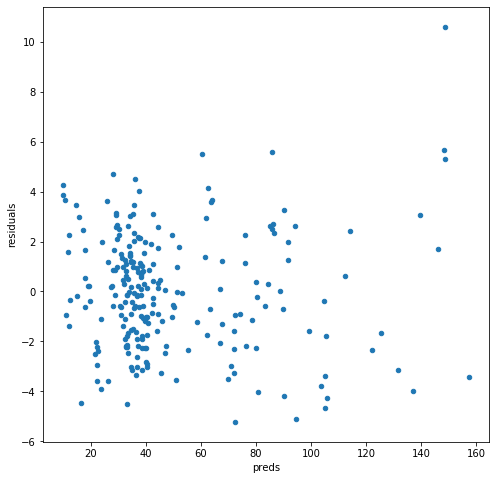

In [100]:
lasso_reg(SUI_rates)

usd1mtd156n       0.000000
mortgage30us      0.000000
mortgage15us      0.000000
dcpf3m            0.000000
cpn3m             0.000000
dcpf1m            0.000000
aaa              -0.000000
baa              -0.000000
dff               0.000000
flexsc            0.000000
t10y2y           -0.000000
t10y3m           -0.000000
tedrate          -0.000000
t10yff           -0.000000
t5yff            -0.000000
tb6smffm          0.000000
usd3mtd156n       0.000000
usd12md156n       0.000000
eur1wkd156n      -0.000000
mprime            0.000000
tb3ms             0.000000
dtb6              0.000000
dgs10             0.000000
dgs3mo            0.000000
dexuseu          -0.000000
dexchus           0.000000
dexusuk           0.000000
dexsius           0.000000
nasdaqcom        -0.003955
willreitind       0.005339
willlrgcap        0.000215
willsmlcap        0.000490
vxdcls           -0.000000
stlfsi           -0.000000
nfci             -0.000000
h8b3094ncba       0.000016
bc0dcbw027nbog    0.005540
c

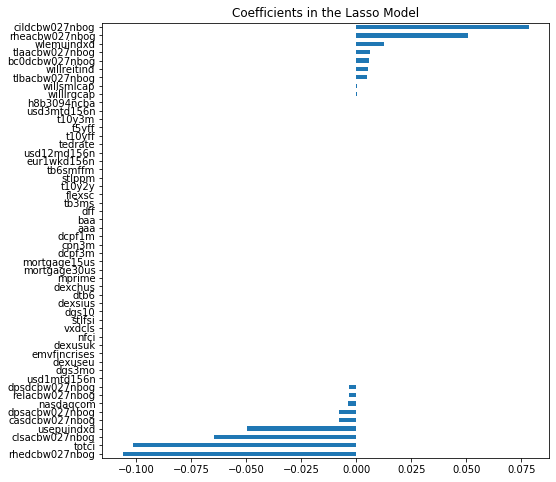

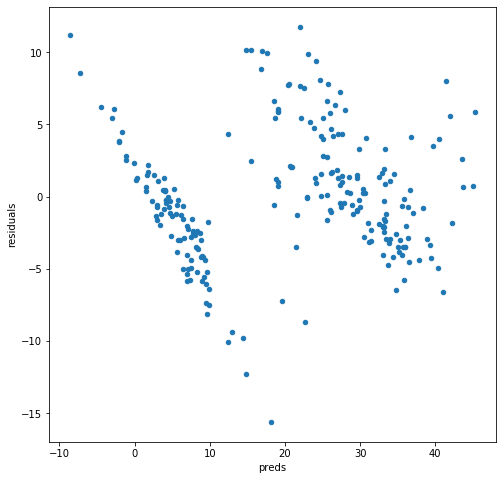

In [101]:
lasso_reg(BXMT_rates)

## Lasso Regression (Least Absolute Shrinkage and Selection Operator)